# Data Challenge Description

The file data.csv contains several columns of information for your analysis. The data are synthetic but were constructed to mimic data that we observe from real-world satellite images.

The car.count column shows the number of cars observed in a parking lot for a retail location like a WalMart or Home Depot. The weather and cloud.indicator columns tell something about whether the parking lot was visible each day.

We would like you to do some exploration of the data, fit some simple models, and summarize what you find, with the goal of both describing the data included and being able to forecast future values. We have in mind this should take no more than a couple of hours.

We are interested to know what you find, but also how you go about finding it. What process? What methods? What intuitions did you use to guide your investigation? Why did you do "this" or "that."

*Please produce some output including plots and other results to explain what you find and how you did it. Don't worry too much about making the output and plots pretty -- well organized is good enough.

Please use any analysis tools and methods that you wish for this project as long as you can explain what each is doing and why you chose to use it. 


Some example questions to answer:

1) Summarize in a qualitative way what you see in the data when you first look it over. What does this suggest for your "plan of attack" for your analysis? What techniques might be appropriate and useful?

2) How would you characterize your findings quantitatively?

3) What additional analysis might be useful if you had a whole day to work on the problem?




Our team will review your work and get back to you. We may ask to schedule a follow-up call if we would like to further review your work with you on a video call.

# Table of Contents
[Feature Engineering](#cell1)

[Linear Regression](#cell2)

[Neural Networks](#cell3)

[Decision Tree Regression](#cell4)

In [1]:
%matplotlib inline
import pandas as pd
from os import listdir
from matplotlib import pyplot as plt
import numpy as np
import glob, re
import seaborn as sns
from datetime import datetime,date
np.random.seed(41)
import calendar
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from scipy.stats import linregress
from statsmodels.graphics.tsaplots import plot_pacf

/home/eminozkan/.conda/envs/challenge/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load and process the data

In [2]:
%%bash
ls data/

data.csv


In [3]:
data = pd.read_csv('data/data.csv')
data.head()

,date,day.of.week,car.count,weather,cloud.indicator
0,2010-01-01,Friday,101,0.1,clear
1,2010-01-02,Saturday,34,0.2,cloudy
2,2010-01-03,Sunday,113,0.4,clear
3,2010-01-04,Monday,5,0.6,cloudy
4,2010-01-05,Tuesday,124,0.1,clear


### Do we have single data point for all dates?

In [4]:
data.shape

(2373, 5)

In [5]:
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date
data['date'].describe()

count           2373
unique          2373
top       2012-01-30
freq               1
Name: date, dtype: object

YES!

### Do we have any missing values?

In [6]:
data.isnull().values.any()

False

In [7]:
data[data.isnull().T.any().T]

,date,day.of.week,car.count,weather,cloud.indicator


NO!

### Is data sorted on dates?

In [8]:
print(data['date'].is_monotonic)
print(data.sample(frac=1)['date'].is_monotonic)
print(data['car.count'].is_monotonic)

True
False
False


### Are there any duplicates?

In [9]:
data[data.drop('date',axis=1).duplicated()].shape

(49, 5)

In [10]:
data[data.drop('date',axis=1).duplicated()].head()

,date,day.of.week,car.count,weather,cloud.indicator
74,2010-03-16,Tuesday,124,0.1,clear
204,2010-07-24,Saturday,121,-0.6,clear
282,2010-10-10,Sunday,125,-0.1,clear
284,2010-10-12,Tuesday,126,0.2,clear
461,2011-04-07,Thursday,42,0.2,cloudy


In [11]:
data[(data['car.count']==124)&(data['weather']==0.1)]

,date,day.of.week,car.count,weather,cloud.indicator
4,2010-01-05,Tuesday,124,0.1,clear
74,2010-03-16,Tuesday,124,0.1,clear
1712,2014-09-09,Tuesday,124,0.1,clear


In [12]:
data[(data['car.count']==121)&(data['weather']==-0.6)]

,date,day.of.week,car.count,weather,cloud.indicator
190,2010-07-10,Saturday,121,-0.6,clear
204,2010-07-24,Saturday,121,-0.6,clear


In [13]:
data[data.drop(['date','day.of.week'],axis=1).duplicated()].shape

(306, 5)

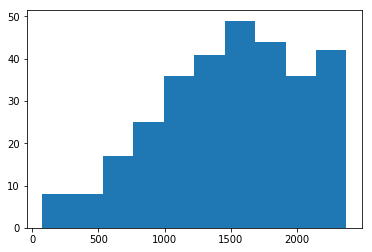

In [14]:
ax = plt.hist(data[data.drop(['date','day.of.week'],axis=1).duplicated()].index)

<a id='cell1'></a>
## Extra feature engineering

### Create date features

In [15]:
data['date'] = pd.to_datetime(data['date'])
data['month.of.year'] = data['date'].dt.month
data['year'] = data['date'].dt.year
data['wom'] = data['date'].dt.day.apply(lambda d: (d-1) // 7 + 1)
data['day'] = data['month.of.year'] = data['date'].dt.day
data['date'] = data['date'].dt.date
data['cloud.indicator_binary'] = data['cloud.indicator'].factorize()[0]
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary
0,2010-01-01,Friday,101,0.1,clear,1,2010,1,1,0
1,2010-01-02,Saturday,34,0.2,cloudy,2,2010,1,2,1
2,2010-01-03,Sunday,113,0.4,clear,3,2010,1,3,0
3,2010-01-04,Monday,5,0.6,cloudy,4,2010,1,4,1
4,2010-01-05,Tuesday,124,0.1,clear,5,2010,1,5,0


### A feature for change from cloudy to clear or vice versa.

In [16]:
data['indicator_change'] = pd.Series(data['cloud.indicator'].factorize()[0]).diff()

In [17]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change
0,2010-01-01,Friday,101,0.1,clear,1,2010,1,1,0,NaN
1,2010-01-02,Saturday,34,0.2,cloudy,2,2010,1,2,1,1.0
2,2010-01-03,Sunday,113,0.4,clear,3,2010,1,3,0,-1.0
3,2010-01-04,Monday,5,0.6,cloudy,4,2010,1,4,1,1.0
4,2010-01-05,Tuesday,124,0.1,clear,5,2010,1,5,0,-1.0


### How many days do we have back to back with the same weather?

In [19]:
data['count_consecutive_cloud.indicator'] = data.groupby((data['cloud.indicator'] != data['cloud.indicator'].shift(1)).cumsum()).cumcount()+1
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator
0,2010-01-01,Friday,101,0.1,clear,1,2010,1,1,0,NaN,1
1,2010-01-02,Saturday,34,0.2,cloudy,2,2010,1,2,1,1.0,1
2,2010-01-03,Sunday,113,0.4,clear,3,2010,1,3,0,-1.0,1
3,2010-01-04,Monday,5,0.6,cloudy,4,2010,1,4,1,1.0,1
4,2010-01-05,Tuesday,124,0.1,clear,5,2010,1,5,0,-1.0,1


### 100 day rolling mean

In [20]:
window = 30
data = data.merge(right = data[['date','car.count']].loc[data['cloud.indicator']=='cloudy'].rolling(window=window).mean().rename(columns={'car.count':'100_moving_ave_cloudy'}),
                  on='date',how='left')
data = data.merge(right = data[['date','car.count']].loc[data['cloud.indicator']=='clear'].rolling(window=window).mean().rename(columns={'car.count':'100_moving_ave'}),
                  on='date',how='left')
data = data.fillna(method='ffill')
print(data.head())
data.tail()

         date day.of.week  car.count  weather cloud.indicator  month.of.year  \
0  2010-01-01      Friday        101      0.1           clear              1   
1  2010-01-02    Saturday         34      0.2          cloudy              2   
2  2010-01-03      Sunday        113      0.4           clear              3   
3  2010-01-04      Monday          5      0.6          cloudy              4   
4  2010-01-05     Tuesday        124      0.1           clear              5   

   year  wom  day  cloud.indicator_binary  indicator_change  \
0  2010    1    1                       0               NaN   
1  2010    1    2                       1               1.0   
2  2010    1    3                       0              -1.0   
3  2010    1    4                       1               1.0   
4  2010    1    5                       0              -1.0   

   count_consecutive_cloud.indicator  100_moving_ave_cloudy  100_moving_ave  
0                                  1                    NaN   

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator,100_moving_ave_cloudy,100_moving_ave
2368,2016-06-26,Sunday,102,0.1,clear,26,2016,4,26,0,0.0,4,52.1,116.466667
2369,2016-06-27,Monday,38,0.6,cloudy,27,2016,4,27,1,1.0,1,52.8,116.466667
2370,2016-06-28,Tuesday,95,-1.6,clear,28,2016,4,28,0,-1.0,1,52.8,115.200000
2371,2016-06-29,Wednesday,104,-0.1,clear,29,2016,5,29,0,0.0,2,52.8,115.866667
2372,2016-06-30,Thursday,90,-0.3,cloudy,30,2016,5,30,1,1.0,1,52.2,115.866667


#### Remove NaN in the beginning:

In [21]:
first_valid_index = data['100_moving_ave'].first_valid_index()
first_valid_index_cloudy = data['100_moving_ave_cloudy'].first_valid_index()
print(first_valid_index,first_valid_index_cloudy)
data = data[data.index>max(first_valid_index,first_valid_index_cloudy)]
data.reset_index(drop=True,inplace=True)
print(data.head())
data.tail()

49 64
         date day.of.week  car.count  weather cloud.indicator  month.of.year  \
0  2010-03-07      Sunday        113      0.0           clear              7   
1  2010-03-08      Monday         46      0.5          cloudy              8   
2  2010-03-09     Tuesday        126      0.2           clear              9   
3  2010-03-10   Wednesday        120      0.3           clear             10   
4  2010-03-11    Thursday         36     -0.7          cloudy             11   

   year  wom  day  cloud.indicator_binary  indicator_change  \
0  2010    1    7                       0              -1.0   
1  2010    2    8                       1               1.0   
2  2010    2    9                       0              -1.0   
3  2010    2   10                       0               0.0   
4  2010    2   11                       1               1.0   

   count_consecutive_cloud.indicator  100_moving_ave_cloudy  100_moving_ave  
0                                  1              61.066

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator,100_moving_ave_cloudy,100_moving_ave
2303,2016-06-26,Sunday,102,0.1,clear,26,2016,4,26,0,0.0,4,52.1,116.466667
2304,2016-06-27,Monday,38,0.6,cloudy,27,2016,4,27,1,1.0,1,52.8,116.466667
2305,2016-06-28,Tuesday,95,-1.6,clear,28,2016,4,28,0,-1.0,1,52.8,115.200000
2306,2016-06-29,Wednesday,104,-0.1,clear,29,2016,5,29,0,0.0,2,52.8,115.866667
2307,2016-06-30,Thursday,90,-0.3,cloudy,30,2016,5,30,1,1.0,1,52.2,115.866667


### Car.count_subtracted feature removes long-term trends

This could be a feature to gain further insights into really high or low values. They do not serve any purpose for a machine learning model because they are constructed using target value. Is there any regularity?

In [22]:
data['car.count_subtracted'] = data['car.count']-data['100_moving_ave']
data['car.count_subtracted_cloudy'] = data['car.count']-data['100_moving_ave_cloudy']
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator,100_moving_ave_cloudy,100_moving_ave,car.count_subtracted,car.count_subtracted_cloudy
0,2010-03-07,Sunday,113,0.0,clear,7,2010,1,7,0,-1.0,1,61.066667,104.433333,8.566667,51.933333
1,2010-03-08,Monday,46,0.5,cloudy,8,2010,2,8,1,1.0,1,61.466667,104.433333,-58.433333,-15.466667
2,2010-03-09,Tuesday,126,0.2,clear,9,2010,2,9,0,-1.0,1,61.466667,105.133333,20.866667,64.533333
3,2010-03-10,Wednesday,120,0.3,clear,10,2010,2,10,0,0.0,2,61.466667,106.000000,14.000000,58.533333
4,2010-03-11,Thursday,36,-0.7,cloudy,11,2010,2,11,1,1.0,1,62.500000,106.000000,-70.000000,-26.500000


### Car.substracted vs date

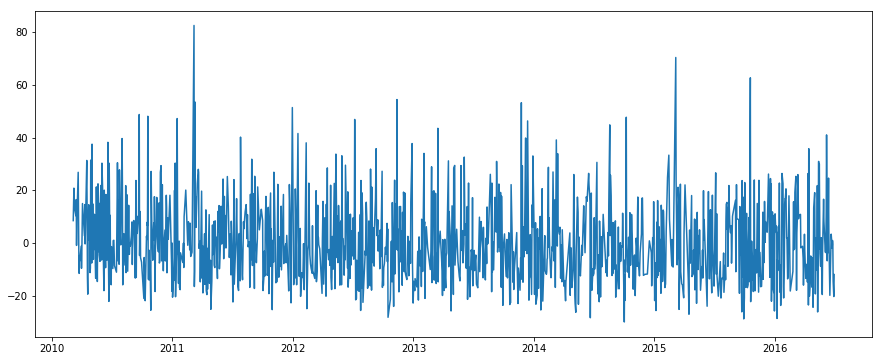

In [23]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear'),'date']
y = data.loc[(data['cloud.indicator']=='clear'),'car.count_subtracted']
plt.plot(x,y)

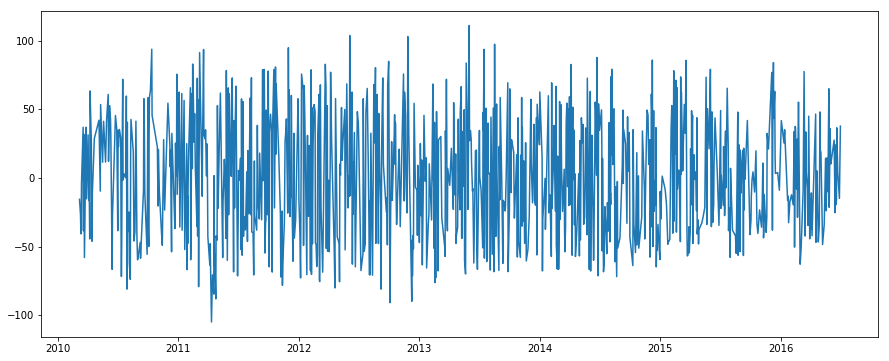

In [24]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='cloudy'),'date']
y = data.loc[(data['cloud.indicator']=='cloudy'),'car.count_subtracted_cloudy']
plt.plot(x,y)

## Distribution of car.count

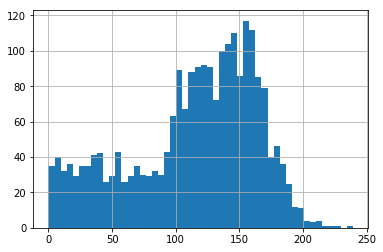

In [25]:
data['car.count'].hist(bins=50)

## Cloud indicator vs car count

### How many different kinds of cloud.indicators are there?
More fine grained cloud indicators could be useful.

In [26]:
data['cloud.indicator'].unique()

array(['clear', 'cloudy'], dtype=object)

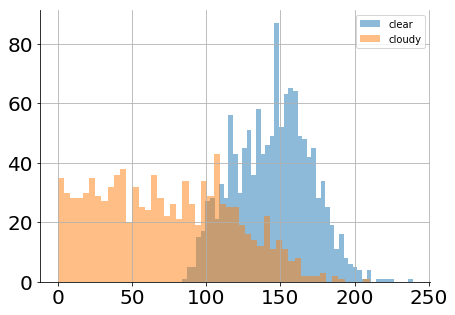

In [27]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[data['cloud.indicator']=='clear','car.count'].hist(bins=50,ax=ax,label='clear',alpha=0.5)
data.loc[data['cloud.indicator']=='cloudy','car.count'].hist(bins=50,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

Clearly the distribution of car counts are very different if we have a cloudy day.

## Does having a lot of back to back clear or cloudy days increase values?

In [29]:
x = data.loc[data['cloud.indicator']=='clear','count_consecutive_cloud.indicator']
y = data.loc[data['cloud.indicator']=='clear','car.count_subtracted']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

0.164600795755 -0.309661391477 0.0209591347195 0.447094629038 0.216438854152


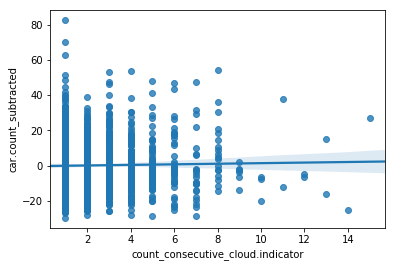

In [30]:
ax = sns.regplot(x='count_consecutive_cloud.indicator', y="car.count_subtracted", data=data[data['cloud.indicator']=='clear'])

In [31]:
x = data.loc[data['cloud.indicator']=='cloudy','count_consecutive_cloud.indicator']
y = data.loc[data['cloud.indicator']=='cloudy','car.count_subtracted_cloudy']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

0.532812932141 -1.14660226732 0.0174869774257 0.582619965525 0.969203832949


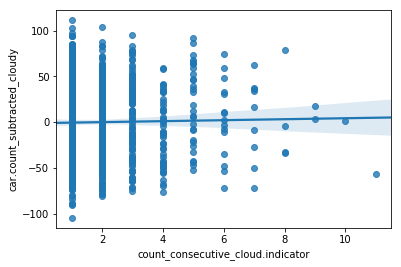

In [32]:
ax = sns.regplot(x='count_consecutive_cloud.indicator', y="car.count_subtracted_cloudy", data=data[data['cloud.indicator']=='cloudy'])

## Date features vs car_count

#### Autocorrelatin and partial autocorrelation

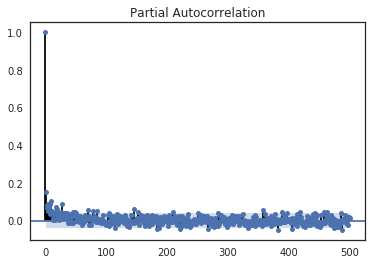

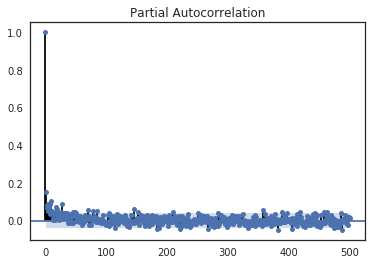

In [114]:
plot_pacf(data['car.count'],lags=500)

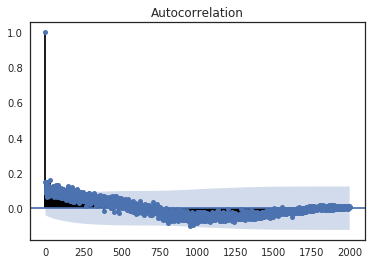

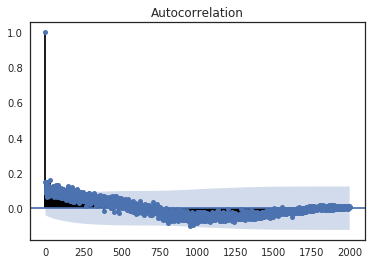

In [113]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['car.count'],lags=2000)

### Weekday vs car

(40, 100)

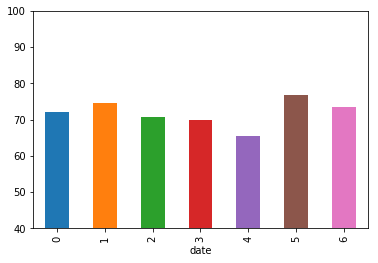

In [33]:
data[data['cloud.indicator']=='cloudy'].groupby(pd.to_datetime(data['date']).dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

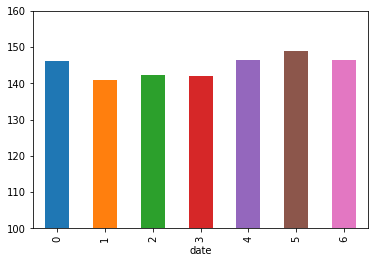

In [34]:
data[data['cloud.indicator']=='clear'].groupby(pd.to_datetime(data['date']).dt.dayofweek)['car.count'].mean().plot.bar()
plt.ylim((100,160))

There doesn't seem to be a strong variation between weekdays. There is also an interaction between weekdays and car count.

#### Day vs car.count

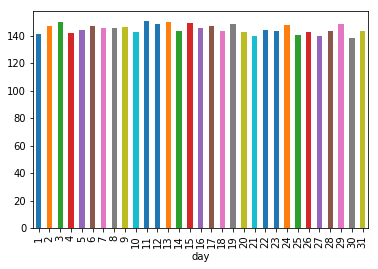

In [35]:
data[data['cloud.indicator']=='clear'].groupby('day')['car.count'].mean().plot.bar()

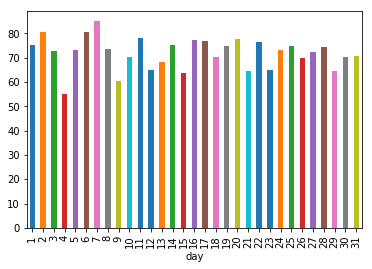

In [36]:
data[data['cloud.indicator']=='cloudy'].groupby('day')['car.count'].mean().plot.bar()

### Is the decrease we have on the 4th day of the month result of having too few samples for that date?

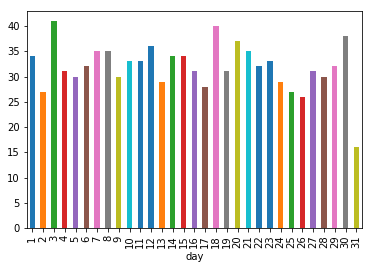

In [44]:
data[data['cloud.indicator']=='cloudy'].groupby('day')['car.count'].count().plot.bar()

### Month vs. car_count

(40, 100)

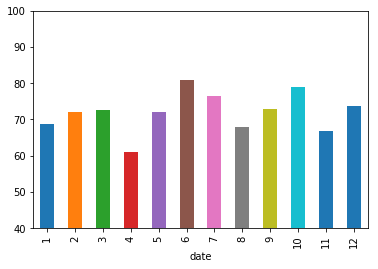

In [45]:
data[data['cloud.indicator']=='cloudy'].groupby(pd.to_datetime(data['date']).dt.month)['car.count'].mean().plot.bar()
plt.ylim((40,100))

(100, 160)

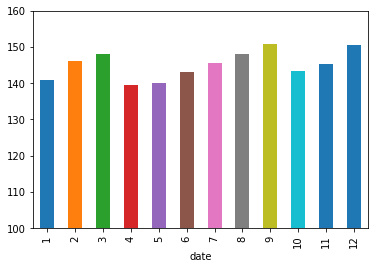

In [46]:
data[data['cloud.indicator']=='clear'].groupby(pd.to_datetime(data['date']).dt.month)['car.count'].mean().plot.bar()
plt.ylim((100,160))

Slightly bigger effect with months, interestingly interaction seems to be very small

### Weak of the month vs car.count

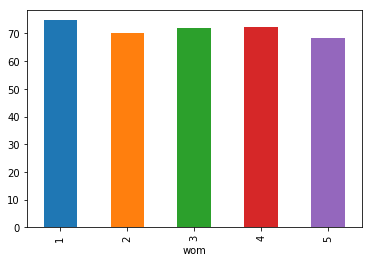

In [47]:
data[data['cloud.indicator']=='cloudy'].groupby('wom')['car.count'].mean().plot.bar()

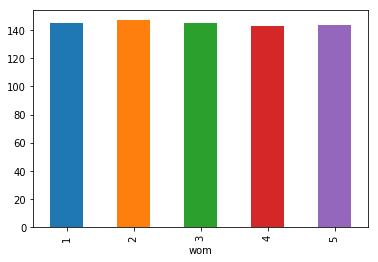

In [48]:
data[data['cloud.indicator']=='clear'].groupby('wom')['car.count'].mean().plot.bar()

### Year vs. car.count

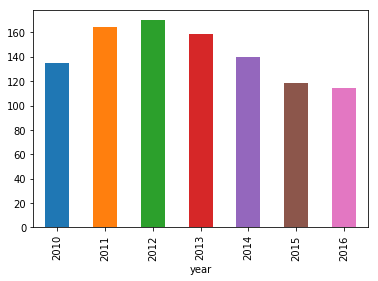

In [49]:
data[data['cloud.indicator']=='clear'].groupby('year')['car.count'].mean().plot.bar()
#plt.ylim((100,160))

Most likely there is recovery after financial crisis followed by retail apocalypse

### Cloud indicator vs month

Should we expect more cloudy days depending on the day of the month?

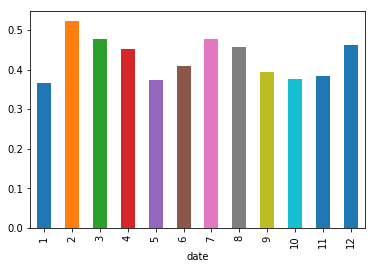

In [50]:
data.groupby(pd.to_datetime(data['date']).dt.month)['cloud.indicator_binary'].mean().plot.bar()

## Weather vs car_count

In [51]:
np.sort(data['weather'].unique())

array([-3.2, -3.1, -3. , -2.9, -2.7, -2.6, -2.5, -2.4, -2.3, -2.2, -2.1,
       -2. , -1.9, -1.8, -1.7, -1.6, -1.5, -1.4, -1.3, -1.2, -1.1, -1. ,
       -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,
        0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,  1.1,  1.2,
        1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,  2.2,  2.3,
        2.4,  2.5,  2.6,  2.7,  2.8,  3. ,  3.1,  3.2,  3.3,  3.8,  4.3])

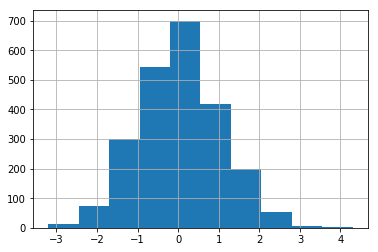

In [52]:
data['weather'].hist()

#### Looks like weather is a standard normal distribution

### Is there a relationship between car.count and weather?

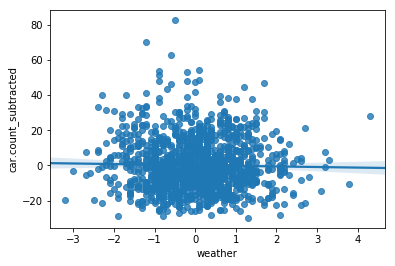

In [53]:
ax = sns.regplot(x="weather", y="car.count_subtracted", data=data[data['cloud.indicator']=='clear'])

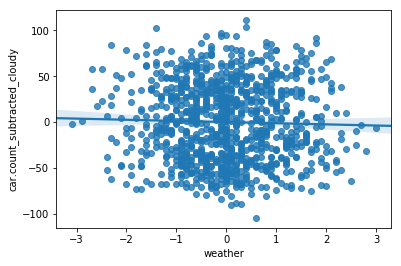

In [54]:
ax = sns.regplot(x="weather", y="car.count_subtracted_cloudy", data=data[(data['cloud.indicator']=='cloudy')])

In [55]:
x = data.loc[data['cloud.indicator']=='clear','weather']
y = data.loc[data['cloud.indicator']=='clear','car.count_subtracted']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

-0.33313461688 0.10083132614 -0.0227380605761 0.409478289023 0.403762612275


In [56]:
x = data.loc[data['cloud.indicator']=='cloudy','weather']
y = data.loc[data['cloud.indicator']=='cloudy','car.count_subtracted_cloudy']
slope, intercept, r_value, p_value, std_err = linregress(x,y)
print(slope, intercept, r_value,p_value,std_err)

-1.25652378915 -0.114913189041 -0.0296467595052 0.351419293479 1.34779571527


### Is there a difference in weather distribution in really high car.count values?

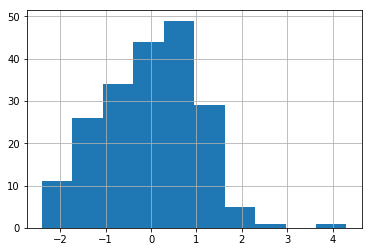

In [57]:
data[data['cloud.indicator']=='clear'].sort_values('car.count_subtracted',ascending=False)[:200]['weather'].hist()

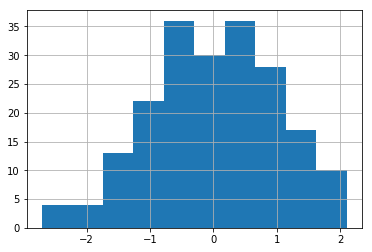

In [58]:
data[data['cloud.indicator']=='cloudy'].sort_values('car.count_subtracted',ascending=False)[:200]['weather'].hist()

There doesn't seem to be an significant relationship between weather and car count.

### Difference in weather in cloudy vs clear days

Normally we would expect cloudy days to be colder.

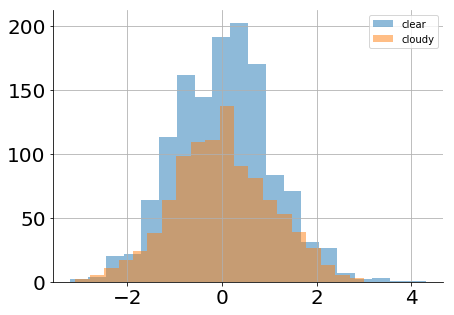

In [59]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='clear'),'weather'].hist(bins=20,ax=ax,label='clear',alpha=0.5)
data.loc[(data['cloud.indicator']=='cloudy'),'weather'].hist(bins=20,ax=ax,label='cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

## Time vs car_count

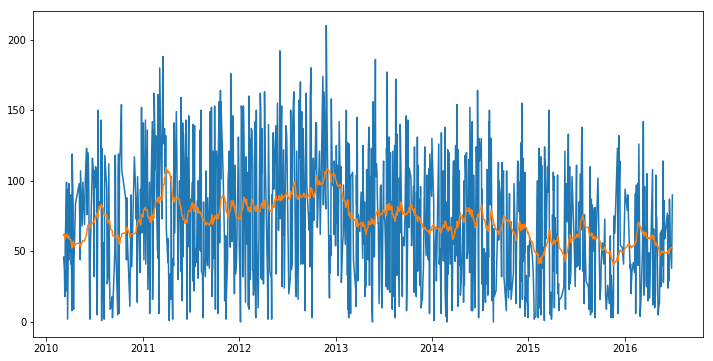

In [60]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='cloudy','date']
y = data.loc[data['cloud.indicator']=='cloudy','car.count']
plt.plot(x,y)
plt.plot(x,data.loc[data['cloud.indicator']=='cloudy','100_moving_ave_cloudy'])

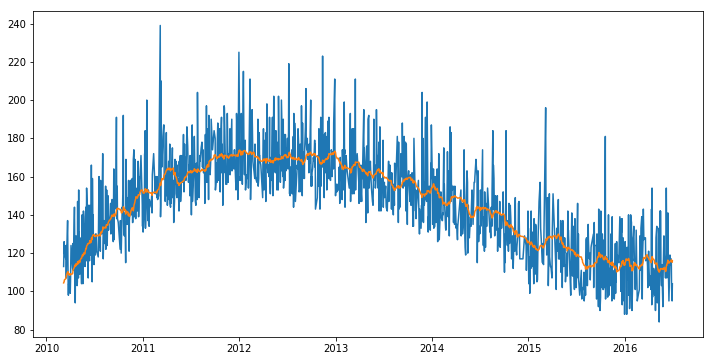

In [61]:
plt.figure(figsize=(12,6))
x = data.loc[data['cloud.indicator']=='clear','date']
y = data.loc[data['cloud.indicator']=='clear','car.count']
plt.plot(x,y)
plt.plot(x,data.loc[data['cloud.indicator']=='clear','100_moving_ave'])

# Are there oscillations within years?

Do we need more moving averages?

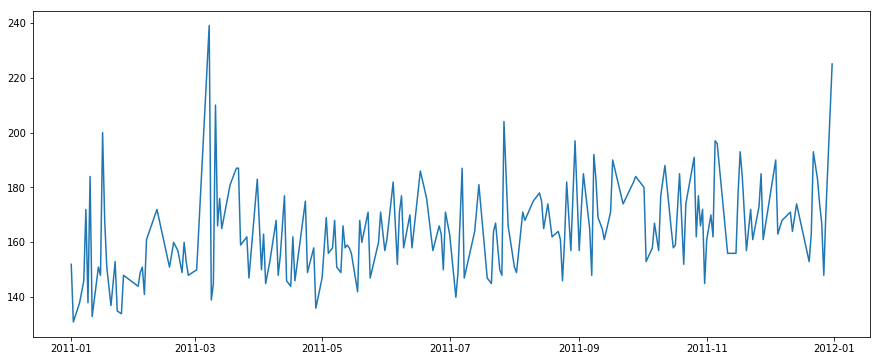

In [62]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2011),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2011),'car.count']
plt.plot(x,y)

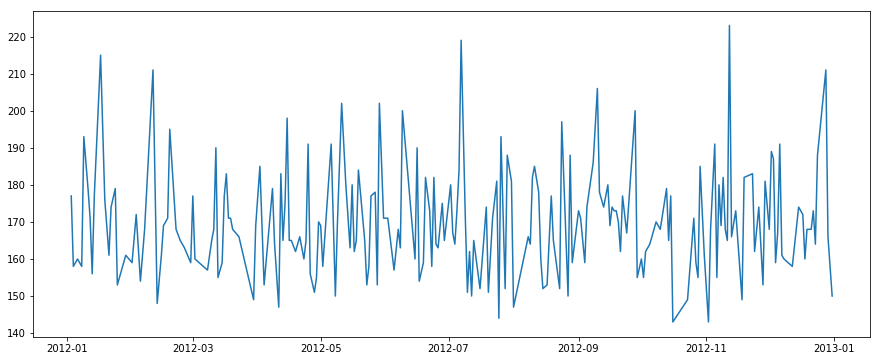

In [63]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'car.count']
plt.plot(x,y)

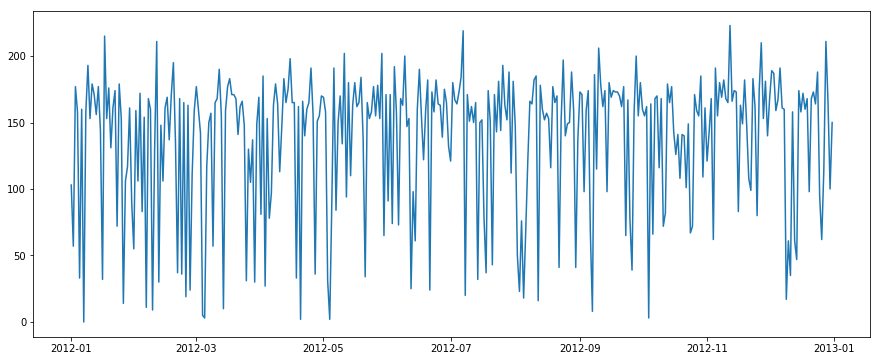

In [64]:
plt.figure(figsize=(15,6))
x = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'car.count']
plt.plot(x,y)

# Could indicator change be a reason for spikes?

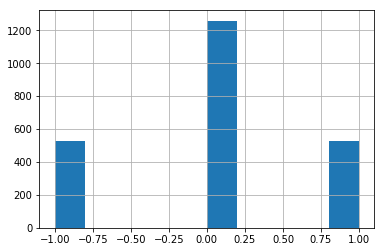

In [65]:
data['indicator_change'].hist()

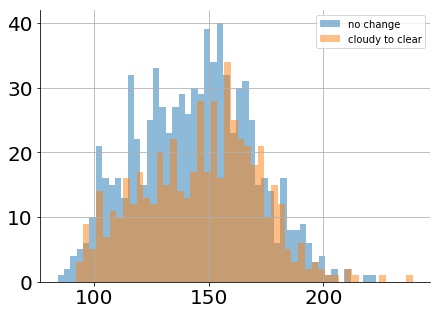

In [66]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='clear')&(data['indicator_change']==0),'car.count'].hist(bins=50,ax=ax,label='no change',alpha=0.5)
data.loc[(data['cloud.indicator']=='clear')&(data['indicator_change']==-1),'car.count'].hist(bins=50,ax=ax,label='cloudy to clear',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

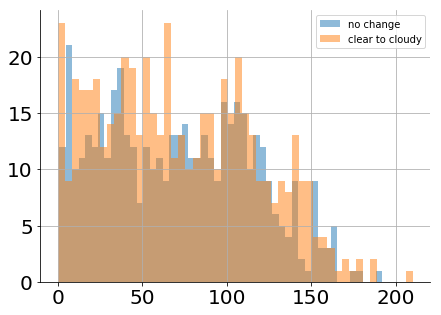

In [67]:
fig = plt.figure(figsize=(7,5))
ax = plt.gca()
data.loc[(data['cloud.indicator']=='cloudy')&(data['indicator_change']==0),'car.count'].hist(bins=50,ax=ax,label='no change',alpha=0.5)
data.loc[(data['cloud.indicator']=='cloudy')&(data['indicator_change']==1),'car.count'].hist(bins=50,ax=ax,label='clear to cloudy',alpha=0.5)
axis_font = {'fontname':'DejaVu Sans', 'size':'22'}
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.legend()

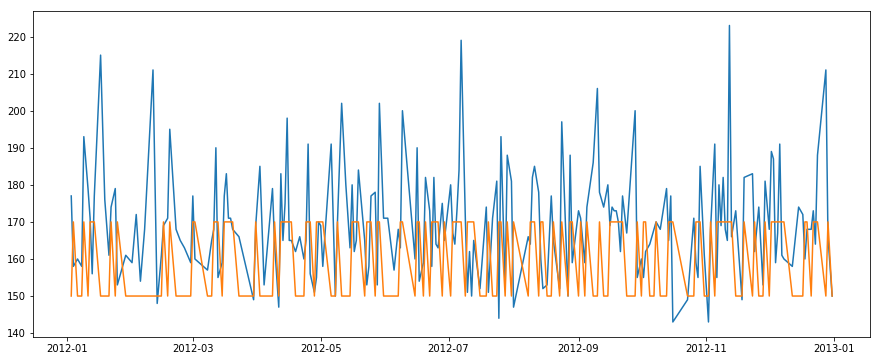

In [68]:
plt.figure(figsize=(15,6))
x = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'car.count']
z = data.loc[(data['cloud.indicator']=='clear')&(pd.to_datetime(data['date']).dt.year==2012),'indicator_change']
z = z*20+170
plt.plot(x,y)
plt.plot(x,z)

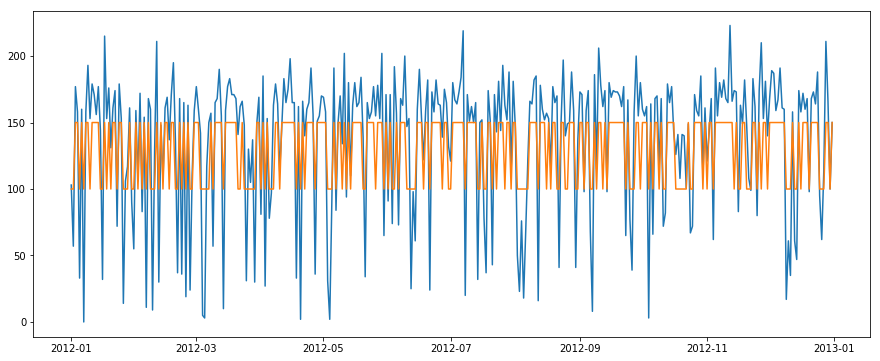

In [69]:
plt.figure(figsize=(15,6))
x = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'date']
y = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'car.count']
z = data.loc[(pd.to_datetime(data['date']).dt.year==2012),'cloud.indicator'].factorize()[0]
z = z*50+100
plt.plot(x,y)
plt.plot(x,z)


<a id='cell2'></a>
# Linear Regression

### Preprocessing steps for Linear Regression

In [70]:
X = pd.concat([pd.get_dummies(data[['day.of.week']]),
               pd.get_dummies(pd.to_datetime(data['date']).dt.month),
               pd.get_dummies(data['indicator_change'].astype(str)),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
              data[['car.count','date']],
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['weather'].values.reshape(-1, 1))[:,0],name='weather'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave'].values.reshape(-1, 1))[:,0],name='100_moving_ave'),
               pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['100_moving_ave_cloudy'].values.reshape(-1, 1))[:,0],name='100_moving_ave'),
              pd.Series(MinMaxScaler(feature_range=(0, 1)).fit_transform(data['count_consecutive_cloud.indicator'].values.reshape(-1, 1))[:,0],name='count_consecutive_cloud.indicator')],
              axis=1)
print(X.columns.tolist())
X.head()

['day.of.week_Friday', 'day.of.week_Monday', 'day.of.week_Saturday', 'day.of.week_Sunday', 'day.of.week_Thursday', 'day.of.week_Tuesday', 'day.of.week_Wednesday', 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, '-1.0', '0.0', '1.0', 'cloud.indicator', 'car.count', 'date', 'weather', '100_moving_ave', '100_moving_ave', 'count_consecutive_cloud.indicator']


/home/eminozkan/.conda/envs/challenge/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,day.of.week_Friday,day.of.week_Monday,day.of.week_Saturday,day.of.week_Sunday,day.of.week_Thursday,day.of.week_Tuesday,day.of.week_Wednesday,1,2,3,...,-1.0,0.0,1.0,cloud.indicator,car.count,date,weather,100_moving_ave,100_moving_ave,count_consecutive_cloud.indicator
0,0,0,0,1,0,0,0,0,0,1,...,1,0,0,0,113,2010-03-07,0.426667,0.000000,0.301687,0.000000
1,0,1,0,0,0,0,0,0,0,1,...,0,0,1,1,46,2010-03-08,0.493333,0.000000,0.307470,0.000000
2,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,126,2010-03-09,0.453333,0.010086,0.307470,0.000000
3,0,0,0,0,0,0,1,0,0,1,...,0,1,0,0,120,2010-03-10,0.466667,0.022574,0.307470,0.071429
4,0,0,0,0,1,0,0,0,0,1,...,0,0,1,1,36,2010-03-11,0.333333,0.022574,0.322410,0.000000


In [71]:
X.isnull().values.any()

False

In [72]:
X_train = X[X['date']<date(2016,1,1)]
X_valid = X[(date(2016,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

(2126, 29) (181, 29)


In [73]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only=True)

In [74]:
def print_metrics(y_true,y_pred):
    y_mean = np.full(y_true.shape,y_true.mean())
    print('R2',r2_score(y_true,y_pred)) # this is R2 value
    print('R2 for the baseline model',r2_score(y_true,y_mean)) # this is R2 value for baseline
    print('explained_variance_score',explained_variance_score(y_true,y_pred)) # this is R2 value
    print('explained_variance_score for the baseline model',explained_variance_score(y_true,y_mean)) # this is explained variance for the mean model
    print('mean_absolute_error',mean_absolute_error(y_true,y_pred)) # this is R2 value
    print('mean_absolute_error for the baseline model',mean_absolute_error(y_true,y_mean)) # this is R2 value
    

# Ridge regression

In [84]:
from sklearn.linear_model import Ridge

x = X_train.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
print('training data dimensions',x.shape)
y_true = X_train['car.count']
clf = Ridge(alpha=100.0, 
            fit_intercept=True, 
            normalize=False, 
            copy_X=True, 
            max_iter=None, 
            tol=0.001, solver='auto', random_state=None)
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

training data dimensions (2126, 379)
R2 0.640023206521
R2 for the baseline model 0.0
explained_variance_score 0.640023206521
explained_variance_score for the baseline model -4.4408920985e-16
mean_absolute_error 22.6756567858
mean_absolute_error for the baseline model 41.757011033


In [86]:
x = X_valid.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

R2 0.549100089797
R2 for the baseline model 0.0
explained_variance_score 0.581503197454
explained_variance_score for the baseline model 0.0
mean_absolute_error 19.7689377138
mean_absolute_error for the baseline model 29.5763865572


### y_true vs y_pred

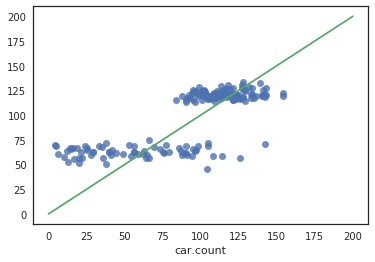

In [87]:
ax = sns.regplot(x=y_true, y=y_pred,fit_reg=False)
plt.plot([0,200],[0,200])

#### Plot below shows the coefficients without interactions (if there are interactions this plot cannot be plotted)

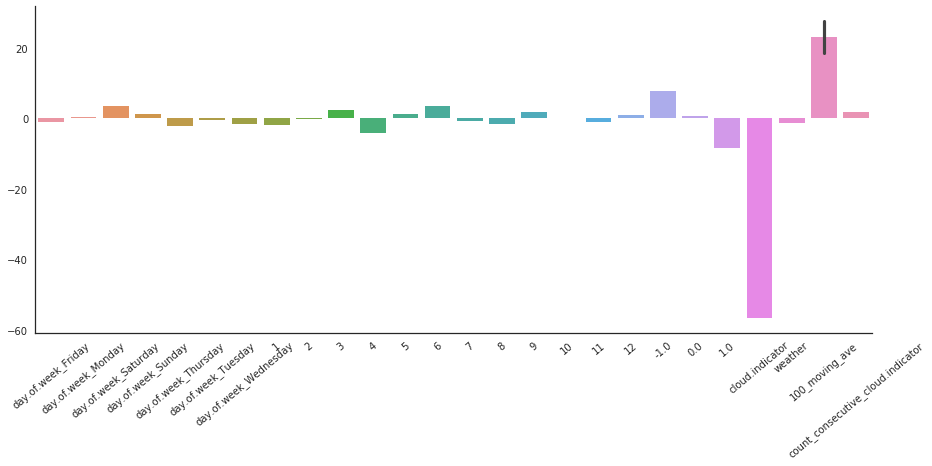

In [83]:
plt.figure(figsize=(15,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

# Lasso

In [88]:
from sklearn.linear_model import Lasso

x = X_train.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_train['car.count']
clf = Lasso(alpha=0.1, fit_intercept=True, 
            normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, 
            warm_start=False, positive=False, random_state=None, selection='cyclic')
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

R2 0.651745732757
R2 for the baseline model 0.0
explained_variance_score 0.651745732757
explained_variance_score for the baseline model -4.4408920985e-16
mean_absolute_error 22.1661667111
mean_absolute_error for the baseline model 41.757011033


In [89]:
x = X_valid.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

R2 0.587553605342
R2 for the baseline model 0.0
explained_variance_score 0.589380055511
explained_variance_score for the baseline model 0.0
mean_absolute_error 18.5141988451
mean_absolute_error for the baseline model 29.5763865572


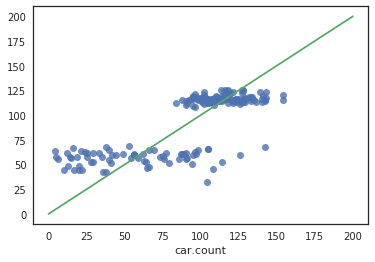

In [90]:
ax = sns.regplot(x=y_true, y=y_pred,fit_reg=False)
plt.plot([0,200],[0,200])

#### How many coefficients are selected?

In [91]:
np.nonzero(clf.coef_)[0].shape

(49,)

#### Plot below shows the coefficients without interactions (if there are interactions this plot cannot be plotted)

In [ ]:
plt.figure(figsize=(20,6))
sns.set(style='white')
ax = sns.barplot(x=x.columns, y =clf.coef_)
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.set_xticklabels(ax.get_xticklabels(),rotation=40)
ax.grid(False)

<a id='cell3'></a>

# Neural Network

In [92]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout, Flatten, Dense,BatchNormalization, GaussianNoise, Activation
from keras import optimizers



train_set = X_train.drop(['date','car.count'],axis=1)
train_labels = X_train['car.count']
valid_set = X_valid.drop(['date','car.count'],axis=1)
valid_labels = X_valid['car.count']


# Create the model
model = Sequential()
model.add(Dense(56, input_shape=train_set.shape[1:]))
model.add(Dense(28, activation='relu'))
model.add(Dense(1, name='three'))
model.summary()

rms_optimizer = optimizers.RMSprop(lr=0.1)
model.compile(loss='mean_squared_error', optimizer=rms_optimizer)

weight_file = 'weights_best.hdf5'

checkpointer = ModelCheckpoint(filepath=weight_file,
                               verbose=1, save_best_only=True)

model.fit(train_set, train_labels,
                 validation_data=(valid_set, valid_labels),
                 epochs=20, batch_size=1024,
                 callbacks=[checkpointer], verbose=2)

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 56)                1568      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1596      
_________________________________________________________________
three (Dense)                (None, 1)                 29        
Total params: 3,193
Trainable params: 3,193
Non-trainable params: 0
_________________________________________________________________
Train on 2126 samples, validate on 181 samples
Epoch 1/20
Epoch 00001: val_loss improved from inf to 1050.77612, saving model to weights_best.hdf5
 - 0s - loss: 36155.3121 - val_loss: 1050.7761
Epoch 2/20
Epoch 00002: val_loss improved from 1050.77612 to 822.24121, saving model to weights_best.hdf5
 - 0s - loss: 1645.4357 - val_loss: 822.2412
Epoch 3/20
Epoch 00003: val_loss did not improve
 - 0s - lo

In [93]:
y_true = X_valid['car.count']
model.load_weights(weight_file)
y_pred =  model.predict(valid_set)[:,0]
print_metrics(y_true,y_pred)

R2 0.539026219744
R2 for the baseline model 0.0
explained_variance_score 0.539397398671
explained_variance_score for the baseline model 0.0
mean_absolute_error 19.221228921
mean_absolute_error for the baseline model 29.5763865572


# KNN

In [94]:
from sklearn.neighbors import KNeighborsRegressor

x = X_train.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_train['car.count']
clf = KNeighborsRegressor(n_neighbors=10, 
                          weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', 
                          metric_params=None, n_jobs=1)
clf.fit(x, y_true) 

y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

R2 0.49359841047
R2 for the baseline model 0.0
explained_variance_score 0.494048236883
explained_variance_score for the baseline model -4.4408920985e-16
mean_absolute_error 27.5477422389
mean_absolute_error for the baseline model 41.757011033


In [95]:
x = X_valid.drop(['date','car.count'],axis=1)
x = poly.fit_transform(x)
y_true = X_valid['car.count']
y_pred = clf.predict(x)
print_metrics(y_true,y_pred)

R2 0.0349066879147
R2 for the baseline model 0.0
explained_variance_score 0.373918238681
explained_variance_score for the baseline model 0.0
mean_absolute_error 28.6640883978
mean_absolute_error for the baseline model 29.5763865572


<a id='cell4'></a>

# Decision tree regression

## Preprocessing steps for decision tree regression

In [96]:
data.head()

,date,day.of.week,car.count,weather,cloud.indicator,month.of.year,year,wom,day,cloud.indicator_binary,indicator_change,count_consecutive_cloud.indicator,100_moving_ave_cloudy,100_moving_ave,car.count_subtracted,car.count_subtracted_cloudy
0,2010-03-07,Sunday,113,0.0,clear,7,2010,1,7,0,-1.0,1,61.066667,104.433333,8.566667,51.933333
1,2010-03-08,Monday,46,0.5,cloudy,8,2010,2,8,1,1.0,1,61.466667,104.433333,-58.433333,-15.466667
2,2010-03-09,Tuesday,126,0.2,clear,9,2010,2,9,0,-1.0,1,61.466667,105.133333,20.866667,64.533333
3,2010-03-10,Wednesday,120,0.3,clear,10,2010,2,10,0,0.0,2,61.466667,106.000000,14.000000,58.533333
4,2010-03-11,Thursday,36,-0.7,cloudy,11,2010,2,11,1,1.0,1,62.500000,106.000000,-70.000000,-26.500000


In [97]:
X = pd.concat([pd.Series(data['month.of.year'].factorize()[0],name='month.of.year'),
                pd.Series(data['cloud.indicator'].factorize()[0],name='cloud.indicator'),
               pd.Series(data['day.of.week'].factorize()[0],name='day.of.week'),
              data[['car.count','date','weather','100_moving_ave','100_moving_ave_cloudy','count_consecutive_cloud.indicator','indicator_change']]],axis=1)
X.head()

,month.of.year,cloud.indicator,day.of.week,car.count,date,weather,100_moving_ave,100_moving_ave_cloudy,count_consecutive_cloud.indicator,indicator_change
0,0,0,0,113,2010-03-07,0.0,104.433333,61.066667,1,-1.0
1,1,1,1,46,2010-03-08,0.5,104.433333,61.466667,1,1.0
2,2,0,2,126,2010-03-09,0.2,105.133333,61.466667,1,-1.0
3,3,0,3,120,2010-03-10,0.3,106.000000,61.466667,2,0.0
4,4,1,4,36,2010-03-11,-0.7,106.000000,62.500000,1,1.0


In [98]:
X_train = X[X['date']<date(2015,1,1)]
X_valid = X[(date(2015,1,1)<X['date'])]
print(X_train.shape,X_valid.shape)

(1761, 10) (546, 10)


In [99]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train.drop(['date','car.count'],axis=1),  X_train['car.count'])

lgb_eval = lgb.Dataset(X_valid.drop(['date','car.count'],axis=1),  X_valid['car.count'])

# specify your configurations as a dict
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': {'mean_squared_error'},
    #'num_leaves': 8,
    'learning_rate': 0.1,
    'verbose': 50,
    'lambda_l2':1
}
print('Start training...')
# train
evals_result = {} 
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=500,
                valid_sets=lgb_eval,
                evals_result=evals_result,
                early_stopping_rounds=1)

Start training...
[1]	valid_0's l2: 2077.09
Training until validation scores don't improve for 1 rounds.
[2]	valid_0's l2: 1829.38
[3]	valid_0's l2: 1616.66
[4]	valid_0's l2: 1459.63
[5]	valid_0's l2: 1317.95
[6]	valid_0's l2: 1184.93
[7]	valid_0's l2: 1111.68
[8]	valid_0's l2: 1049.27
[9]	valid_0's l2: 996.771
[10]	valid_0's l2: 959.86
[11]	valid_0's l2: 906.323
[12]	valid_0's l2: 878.042
[13]	valid_0's l2: 856.557
[14]	valid_0's l2: 839.261
[15]	valid_0's l2: 823.782
[16]	valid_0's l2: 812.7
[17]	valid_0's l2: 802.36
[18]	valid_0's l2: 793.677
[19]	valid_0's l2: 787.151
[20]	valid_0's l2: 779.135
[21]	valid_0's l2: 771.061
[22]	valid_0's l2: 765.809
[23]	valid_0's l2: 763.076
[24]	valid_0's l2: 761.36
[25]	valid_0's l2: 758.709
[26]	valid_0's l2: 756.688
[27]	valid_0's l2: 754.735
[28]	valid_0's l2: 754.515
[29]	valid_0's l2: 757.075
Early stopping, best iteration is:
[28]	valid_0's l2: 754.515


In [100]:
x = X_valid.drop(['date','car.count'],axis=1)
y_true = X_valid['car.count']
y_pred = gbm.predict(x, num_iteration=gbm.best_iteration)
print_metrics(y_true,y_pred)

R2 0.524548225105
R2 for the baseline model 0.0
explained_variance_score 0.554669197771
explained_variance_score for the baseline model 0.0
mean_absolute_error 21.3052097906
mean_absolute_error for the baseline model 32.5766413074


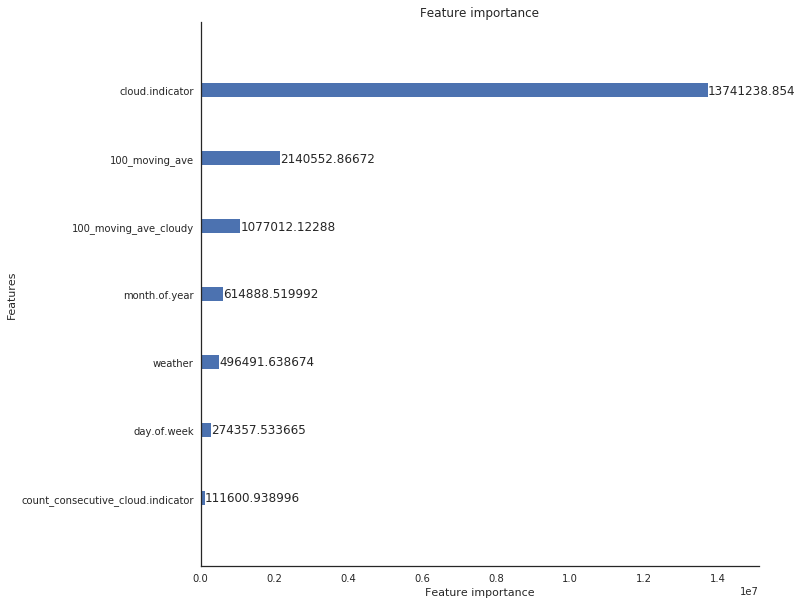

In [101]:
fig = plt.figure(figsize=(10,10))
ax = plt.gca()
lgb.plot_importance(gbm,ax=ax,importance_type='gain')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.grid(False)
plt.show()

## RNN

In [102]:
data = pd.read_csv('data/data.csv')
data['cloud.indicator'] = data['cloud.indicator'].factorize()[0]
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.date
print(data.shape)
data.head()

(2373, 5)


,date,day.of.week,car.count,weather,cloud.indicator
0,2010-01-01,Friday,101,0.1,0
1,2010-01-02,Saturday,34,0.2,1
2,2010-01-03,Sunday,113,0.4,0
3,2010-01-04,Monday,5,0.6,1
4,2010-01-05,Tuesday,124,0.1,0


In [103]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1,include_target=0):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back+include_target)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [104]:
look_back=20
X_cars, y_cars = create_dataset(data['car.count'].as_matrix(),look_back,0)
X_clouds, y_clouds = create_dataset(data['cloud.indicator'].as_matrix(),look_back,1)

X = np.zeros(shape=(X_clouds.shape[0],X_clouds.shape[1],2))
X_cars = MinMaxScaler(feature_range=(0, 1)).fit_transform(X_cars)
X[:,1:,0]=X_cars
X[:,:,1]=X_clouds


train_split=2000
train_set,valid_set,train_labels,valid_labels = X[:train_split],X[train_split:],y_cars[:train_split],y_cars[train_split:]


print(train_set.shape,train_labels.shape)
print(valid_set.shape,valid_labels.shape)
print(train_set[1])
train_labels[1]

(2000, 21, 2) (2000,)
(352, 21, 2) (352,)
[[ 0.          1.        ]
 [ 0.14225941  0.        ]
 [ 0.47280335  1.        ]
 [ 0.0209205   0.        ]
 [ 0.51882845  0.        ]
 [ 0.43514644  0.        ]
 [ 0.33891213  1.        ]
 [ 0.28033473  1.        ]
 [ 0.37238494  0.        ]
 [ 0.55230126  0.        ]
 [ 0.43933054  0.        ]
 [ 0.39330544  0.        ]
 [ 0.41422594  1.        ]
 [ 0.10041841  0.        ]
 [ 0.41004184  1.        ]
 [ 0.12970711  1.        ]
 [ 0.28870293  0.        ]
 [ 0.40167364  0.        ]
 [ 0.39330544  0.        ]
 [ 0.38075314  1.        ]
 [ 0.17573222  0.        ]]


/home/eminozkan/.conda/envs/challenge/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


101

In [105]:
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dropout, Flatten, Dense,BatchNormalization, GaussianNoise, Activation
from keras import optimizers
from keras.layers import LSTM,SimpleRNN



# Create the model
model = Sequential()
model.add(SimpleRNN(10, input_shape=train_set.shape[1:]))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, name='three'))
model.summary()

rms_optimizer = optimizers.RMSprop(lr=0.05)
model.compile(loss='mean_squared_error', optimizer=rms_optimizer)

weight_file = 'weights_best.hdf5'

checkpointer = ModelCheckpoint(filepath=weight_file,
                               verbose=2, save_best_only=True)

history = model.fit(train_set, train_labels,
                 validation_data=(valid_set, valid_labels),
                 epochs=100, batch_size=1024,
                 callbacks=[checkpointer], verbose=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                130       
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
three (Dense)                (None, 1)                 11        
Total params: 251
Trainable params: 251
Non-trainable params: 0
_________________________________________________________________
Train on 2000 samples, validate on 352 samples
Epoch 1/100
Epoch 00001: val_loss improved from inf to 9000.11035, saving model to weights_best.hdf5
 - 0s - loss: 16054.9998 - val_loss: 9000.1104
Epoch 2/100
Epoch 00002: val_loss improved from 9000.11035 to 6951.37939, saving model to weights_best.hdf5
 - 0s - loss: 14706.4977 - val_loss: 6951.3794
Epoch 3/100
Epoch 00003: val_loss did not improve
 - 0s - 

Epoch 70/100
Epoch 00070: val_loss did not improve
 - 0s - loss: 1251.3409 - val_loss: 1535.5435
Epoch 71/100
Epoch 00071: val_loss did not improve
 - 0s - loss: 1195.8029 - val_loss: 1508.9023
Epoch 72/100
Epoch 00072: val_loss did not improve
 - 0s - loss: 1195.5606 - val_loss: 1543.1211
Epoch 73/100
Epoch 00073: val_loss did not improve
 - 0s - loss: 1199.5580 - val_loss: 1806.7443
Epoch 74/100
Epoch 00074: val_loss did not improve
 - 0s - loss: 1260.0755 - val_loss: 2052.1775
Epoch 75/100
Epoch 00075: val_loss did not improve
 - 0s - loss: 1293.1735 - val_loss: 1953.5302
Epoch 76/100
Epoch 00076: val_loss did not improve
 - 0s - loss: 1247.8800 - val_loss: 1788.8140
Epoch 77/100
Epoch 00077: val_loss did not improve
 - 0s - loss: 1213.4059 - val_loss: 1657.9570
Epoch 78/100
Epoch 00078: val_loss did not improve
 - 0s - loss: 1196.3889 - val_loss: 1498.8606
Epoch 79/100
Epoch 00079: val_loss did not improve
 - 0s - loss: 1193.1391 - val_loss: 1578.7555
Epoch 80/100
Epoch 00080: val_

In [106]:
print(history.history.keys())

dict_keys(['loss', 'val_loss'])


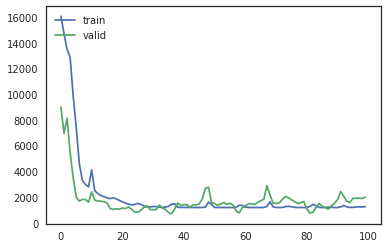

In [107]:
ax = plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train', 'valid'], loc='upper left')

In [108]:
model.load_weights(weight_file)
y_pred =  model.predict(valid_set)[:,0]
print_metrics(valid_labels,y_pred)

R2 0.506628661828
R2 for the baseline model 0.0
explained_variance_score 0.576744512043
explained_variance_score for the baseline model 0.0
mean_absolute_error 21.2838377844
mean_absolute_error for the baseline model 30.0608374225


# Conclusion:

I started by making sure that there are no missing values and the data is sorted on date. This is pretty important for time-series data. After EDA, I found that having a cloudy day impairs having an accurate estimate of car counts. There are weak variations in car counts depending on the day of the week or month of the year. I also did not find a correlation between weather and car counts. There was however strong long term trends when looking at years seperately, with the highest amount of cars present in 2012. I also constructed models in order to predict feature values of car counts. My initial models were really bad. However by including a 100 day moving median, I was able to capture long-term trends, and this significantly improved my models. I was able to obtain R2 value of around 0.4 in the validation data, which is not great, but it shows that we have a significant imporevement compared to a mean model. Looking for coefficients of both linear models and non-linear models we can see that the most important coefficient is cloud_indicator, and this makes sense. If it is cloudy there are less cars. The second most important coefficient is 100-day moving average, and the other coefficients have a very small role in terms of being able to predict the number of car counts.

Given more time I would:

1) Tune models; for example find the best regularization coefficients.

2) Try to work on identifying outliers by doing someting like bollinger bands or RSI (this was a question in my phone talk with Steve).


3) Include week of the month and see if this imporves the model (I doubt it) (DONE)

4) Engineer another feature such as how many days back to back it was cloudy and clear etc. It could be that having a lot of cloudy or clear days together may change people's mood and they may visit a store more or less. (DONE)

5) Try to plot the names of the interaction coefficients.

6) Build a recurrent model